In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [19]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filename="../../data/HG002/variants/GangSTR/HG002.GRCh38.2x250_GangSTR.vcf", samples=["HG002.GRCh38.2x250"], format="GangSTR")

df_covered_repeats = pd.read_csv("../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

df_hg002 = df_hg002.merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "period", "unit", "ref"]], on="str_id", how="inner"
).assign(
    copy_number = lambda x: [2 if i in autosomes else 1 for i in x["chr"]] # GangSTR doesn't include CN so we add it manually here
).dropna().reset_index(drop=True)

df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref
0,HG002.GRCh38.2x250,chr1_588068,2,{4: 22},"[4, 4]",chr1,588068,588079,3,cct,4
1,HG002.GRCh38.2x250,chr1_589245,2,{6: 6},"[6, 6]",chr1,589245,589256,2,tc,6
2,HG002.GRCh38.2x250,chr1_590659,2,{3: 50},"[3, 3]",chr1,590659,590670,4,aaat,3
3,HG002.GRCh38.2x250,chr1_590969,2,{4: 35},"[4, 4]",chr1,590969,590984,4,aaac,4
4,HG002.GRCh38.2x250,chr1_591734,2,{20: 9},"[20, 20]",chr1,591734,591751,1,a,18
...,...,...,...,...,...,...,...,...,...,...,...
1654564,HG002.GRCh38.2x250,chrY_26627699,1,{4: 21},[4],chrY,26627699,26627710,3,gaa,4
1654565,HG002.GRCh38.2x250,chrY_26628607,1,{3: 24},[3],chrY,26628607,26628621,5,atttt,3
1654566,HG002.GRCh38.2x250,chrY_26632688,1,{6: 7},[6],chrY,26632688,26632705,3,ttc,6
1654567,HG002.GRCh38.2x250,chrY_26635262,1,{10: 25},[10],chrY,26635262,26635271,1,a,10


In [20]:
df_strs_haplotypes = pd.read_csv("../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv").assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [21]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [22]:
df_hg002 = df_hg002.assign(
    illumina_region_len = lambda x: [sorted([k * j for k in i]) for i, j in zip(x["genotype"], x["period"])],
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
)
df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref,illumina_region_len,depth
0,HG002.GRCh38.2x250,chr1_588068,2,{4: 22},"[4, 4]",chr1,588068,588079,3,cct,4,"[12, 12]",22
1,HG002.GRCh38.2x250,chr1_589245,2,{6: 6},"[6, 6]",chr1,589245,589256,2,tc,6,"[12, 12]",6
2,HG002.GRCh38.2x250,chr1_590659,2,{3: 50},"[3, 3]",chr1,590659,590670,4,aaat,3,"[12, 12]",50
3,HG002.GRCh38.2x250,chr1_590969,2,{4: 35},"[4, 4]",chr1,590969,590984,4,aaac,4,"[16, 16]",35
4,HG002.GRCh38.2x250,chr1_591734,2,{20: 9},"[20, 20]",chr1,591734,591751,1,a,18,"[20, 20]",9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654564,HG002.GRCh38.2x250,chrY_26627699,1,{4: 21},[4],chrY,26627699,26627710,3,gaa,4,[12],21
1654565,HG002.GRCh38.2x250,chrY_26628607,1,{3: 24},[3],chrY,26628607,26628621,5,atttt,3,[15],24
1654566,HG002.GRCh38.2x250,chrY_26632688,1,{6: 7},[6],chrY,26632688,26632705,3,ttc,6,[18],7
1654567,HG002.GRCh38.2x250,chrY_26635262,1,{10: 25},[10],chrY,26635262,26635271,1,a,10,[10],25


In [23]:
def soft_match(a, b, tolerance = 1):
    """a and b must both be sorted in ascending order"""
    checks = []
    for i, j in zip(a, b):
        checks.append(j - tolerance <= i <= j + tolerance)
    return all(checks)
print(soft_match([13, 14], [14, 14]))
print(soft_match([12, 14], [14, 14]))

True
False


In [24]:
tolerance = 1
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
            softmatch = lambda x: [soft_match(i, j, tolerance) for i, j in zip(x["illumina_region_len"], x["haplo_region_len"])]
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,match,softmatch
0,chr1_588068,"[12, 12]","[12, 12]",True,True
1,chr1_589245,"[12, 12]","[12, 12]",True,True
2,chr1_590659,"[12, 12]","[12, 12]",True,True
3,chr1_590969,"[16, 16]","[16, 16]",True,True
4,chr1_591734,"[20, 20]","[20, 20]",True,True
...,...,...,...,...,...
1654564,chrY_26627699,[12],[12],True,True
1654565,chrY_26628607,[15],[15],True,True
1654566,chrY_26632688,[19],[18],False,True
1654567,chrY_26635262,[10],[10],True,True


In [25]:
print("Overall accuracy:", (1 - (df_comparison.loc[~df_comparison["match"]].shape[0] / df_comparison.shape[0])) * 100)
print("Overall accuracy (softmatch):", (1 - (df_comparison.loc[~df_comparison["softmatch"]].shape[0] / df_comparison.shape[0])) * 100)
df_comparison.loc[~df_comparison["match"]]

Overall accuracy: 95.12948689356564
Overall accuracy (softmatch): 97.29119788899708


,str_id,haplo_region_len,illumina_region_len,match,softmatch
31,chr1_647491,"[18, 18]","[18, 19]",False,True
35,chr1_651961,"[16, 16]","[16, 17]",False,True
50,chr1_720655,"[15, 15]","[16, 16]",False,True
58,chr1_739603,"[10, 10]","[10, 11]",False,True
60,chr1_744867,"[32, 34]","[14, 14]",False,False
...,...,...,...,...,...
1654320,chrY_25102422,[20],[18],False,False
1654321,chrY_25109110,[13],[14],False,True
1654329,chrY_26169682,[42],[40],False,False
1654348,chrY_26331846,[15],[18],False,False


In [26]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 4).reshape(-1, 1), np.tile([1, 10, 10, 20, 20, 30, 30, 1000000], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy_match = []
accuracy_softmatch = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_hg002
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    n.append(df_comparison_filt.shape[0])
    accuracy_match.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)
    accuracy_softmatch.append((1 - (df_comparison_filt.loc[~df_comparison_filt["softmatch"]].shape[0] / df_comparison_filt.shape[0])) * 100)    

df_plot["n"] = n
df_plot["accuracy_match"] = accuracy_match
df_plot["accuracy_softmatch"] = accuracy_softmatch
df_plot["depth"] = np.tile(["1-10", "10-20", "20-30", "30-"], 6)

df_plot

,period,depth_lower,depth_upper,n,accuracy_match,accuracy_softmatch,depth
0,1,1,10,205858,79.682111,89.401432,1-10
1,1,10,20,287640,96.041927,98.437978,10-20
2,1,20,30,325903,98.156814,99.418845,20-30
3,1,30,1000000,33129,97.847807,99.281596,30-
4,2,1,10,7257,53.272702,62.629186,1-10
5,2,10,20,32263,88.646437,90.276788,10-20
6,2,20,30,66566,97.072079,97.459664,20-30
7,2,30,1000000,12365,98.584715,98.689850,30-
8,3,1,10,3547,72.878489,82.492247,1-10
9,3,10,20,19804,95.349424,96.642093,10-20


[None, None]

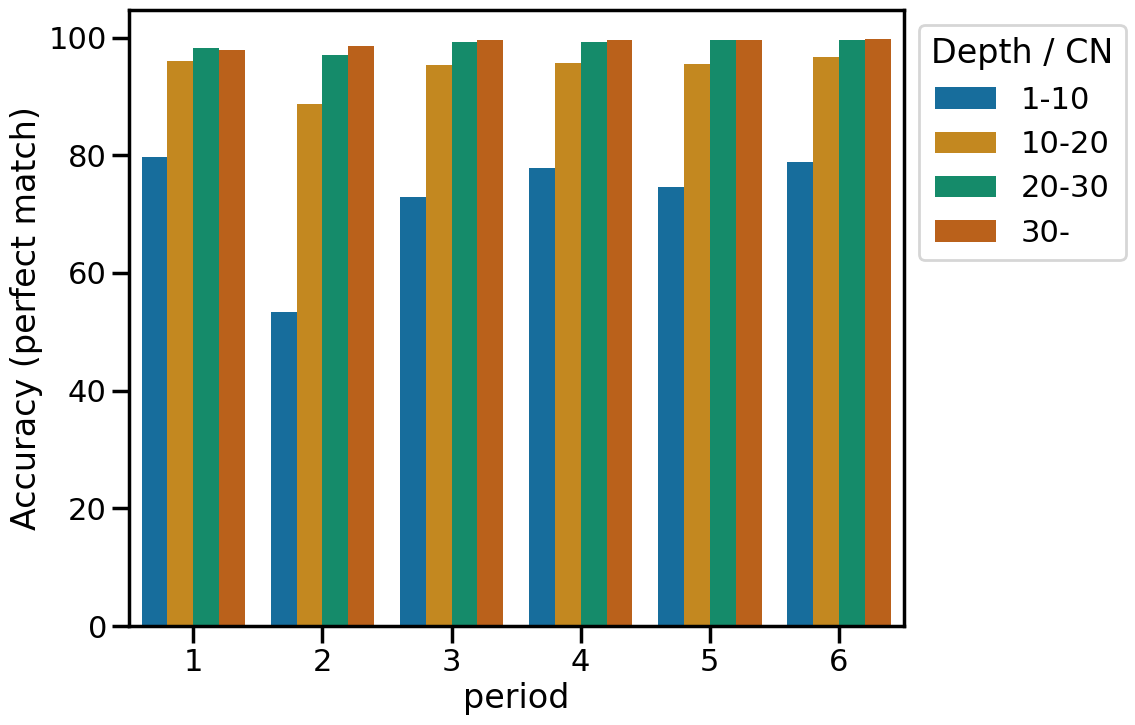

In [27]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy_match",
    hue="depth",
    palette="colorblind"
)

ax.set(
    ylabel = "Accuracy (perfect match)"
)

ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

In [28]:
from scipy import ndimage

max_period = 6
max_depth = 200
min_obs = 15

df_plot_cn = (
    df_comparison
        .merge(df_hg002[["chr", "str_id", "period", "depth", "copy_number"]], on="str_id")        
        .query(f"depth <= {max_depth} and period <= {max_period}")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_cn.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_cn = df_plot_cn.assign(smooth = np.concatenate(smooth))

df_plot_cn

,period,depth,accuracy,n_obs,smooth
0,1,1.0,0.370379,12282,0.569459
1,1,1.5,0.488185,10072,0.587741
2,1,2.0,0.633123,12064,0.620650
3,1,2.5,0.694986,11288,0.662204
4,1,3.0,0.775050,12585,0.706070
...,...,...,...,...,...
805,6,37.0,1.000000,50,0.995267
806,6,37.5,1.000000,25,0.994805
807,6,38.0,0.969697,33,0.994453
808,6,38.5,1.000000,17,0.994235


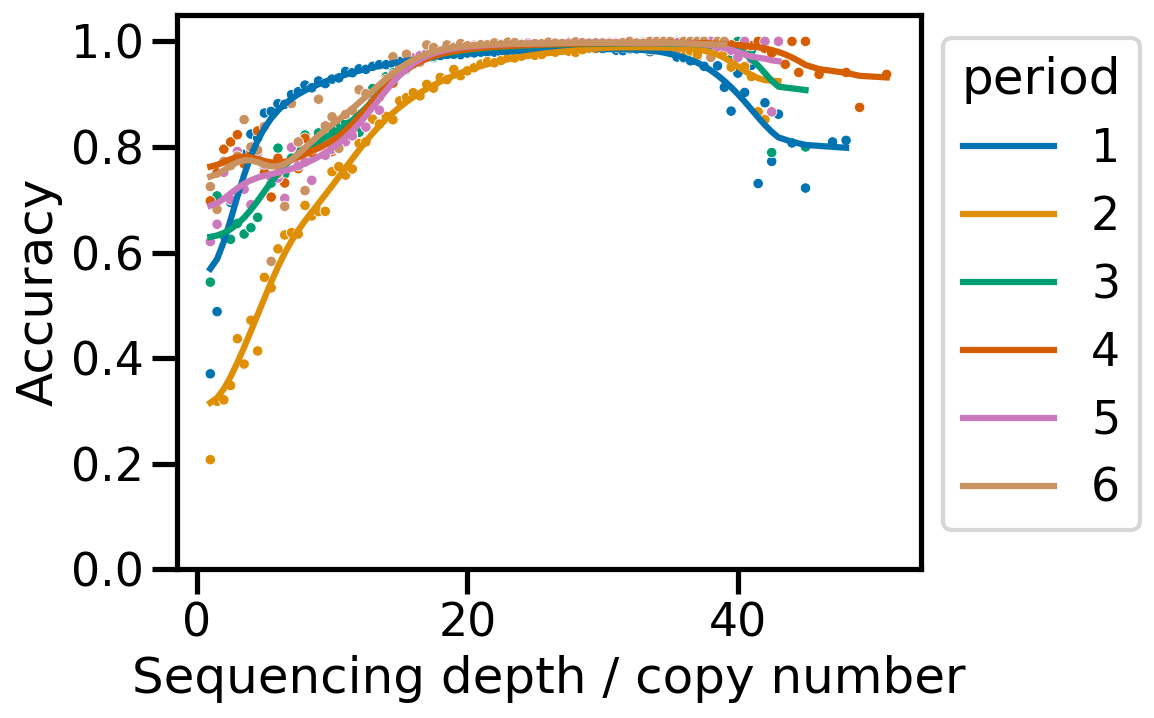

In [29]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_cn,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind",
    # linewidth=2
)

ax = sns.scatterplot(
    df_plot_cn,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    xlabel = "Sequencing depth / copy number",
    ylabel = "Accuracy",
    ylim=(0, 1.05)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()

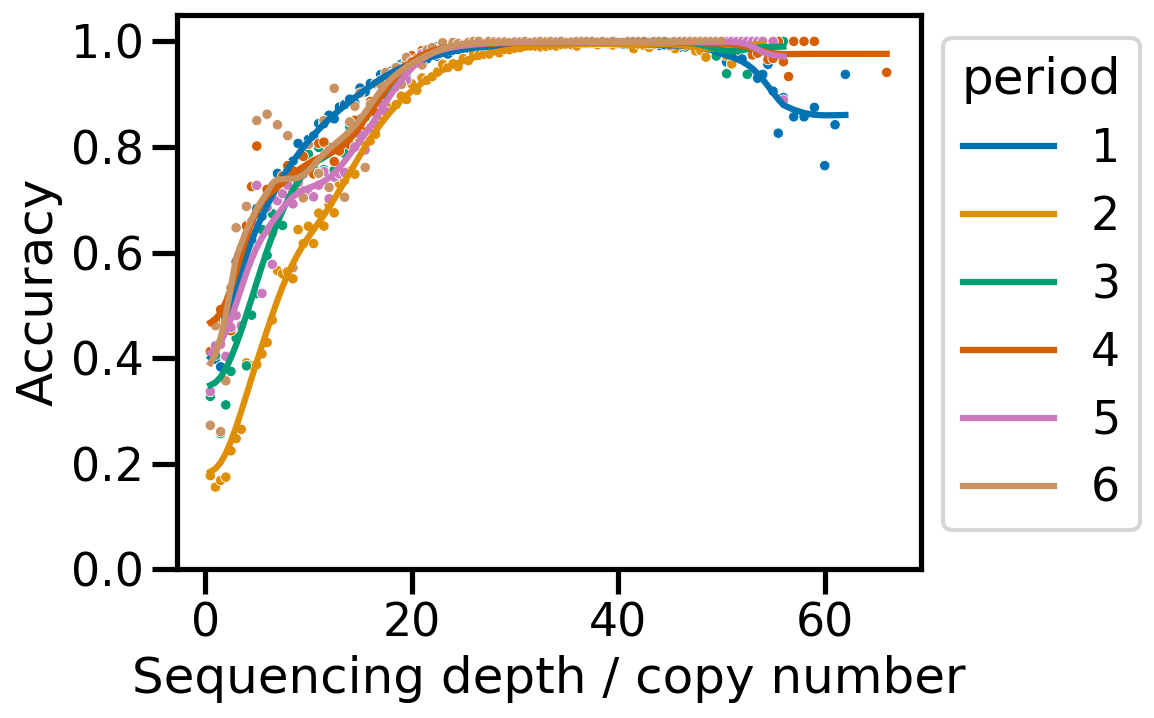

In [14]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_cn,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind",
    # linewidth=2
)

ax = sns.scatterplot(
    df_plot_cn,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    xlabel = "Sequencing depth / copy number",
    ylabel = "Accuracy",
    ylim=(0, 1.05)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()

In [33]:
(
    df_hg002
        .query("period == 2 & depth > 100 & depth < 125")
        .sort_values("depth", ascending= False)
        .merge(df_strs_haplotypes[["str_id", "haplo_region_len"]], on="str_id")
        .query("illumina_region_len != haplo_region_len")
        .head(50)[["period", "frequencies", "illumina_region_len", "haplo_region_len"]]
)

,period,frequencies,illumina_region_len,haplo_region_len
1,2,"{8: 82, 12: 2, 13: 14, 14: 7, 15: 9, 18: 7}","[16, 28]","[16, 16]"
2,2,"{5: 34, 6: 86}","[10, 12]","[12, 12]"
4,2,"{17: 2, 18: 18, 20: 17, 21: 13, 22: 38, 23: 14...","[36, 44]","[36, 40]"
8,2,"{13: 2, 14: 59, 15: 28, 16: 24}","[28, 32]","[28, 28]"
10,2,"{6: 46, 7: 40, 8: 26}","[12, 14]","[14, 16]"
17,2,"{20: 19, 21: 22, 23: 33, 24: 21, 26: 9}",[46],[45]


In [34]:
max_period = 6
max_depth = 200
min_obs = 10
df_plot_sex = (
    df_comparison
        .merge(df_hg002[["chr", "str_id", "period", "depth"]], on="str_id")
        .query("chr == 'chrX' or chr == 'chrY'")
        .query(f"depth <= {max_depth} and period <= {max_period}")[["match", "period", "depth"]]
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_sex.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 2, mode="reflect")
    smooth.append(current_smooth)
df_plot_sex = df_plot_sex.assign(smooth = np.concatenate(smooth))

df_plot_sex

,period,depth,accuracy,n_obs,smooth
0,1,2,0.913158,1140,0.941693
1,1,3,0.964508,1127,0.945436
2,1,4,0.946626,993,0.951364
3,1,5,0.962860,1077,0.957721
4,1,6,0.958564,1086,0.963542
...,...,...,...,...,...
357,6,33,1.000000,41,0.999977
358,6,34,1.000000,31,0.999996
359,6,35,1.000000,24,0.999999
360,6,36,1.000000,15,1.000000


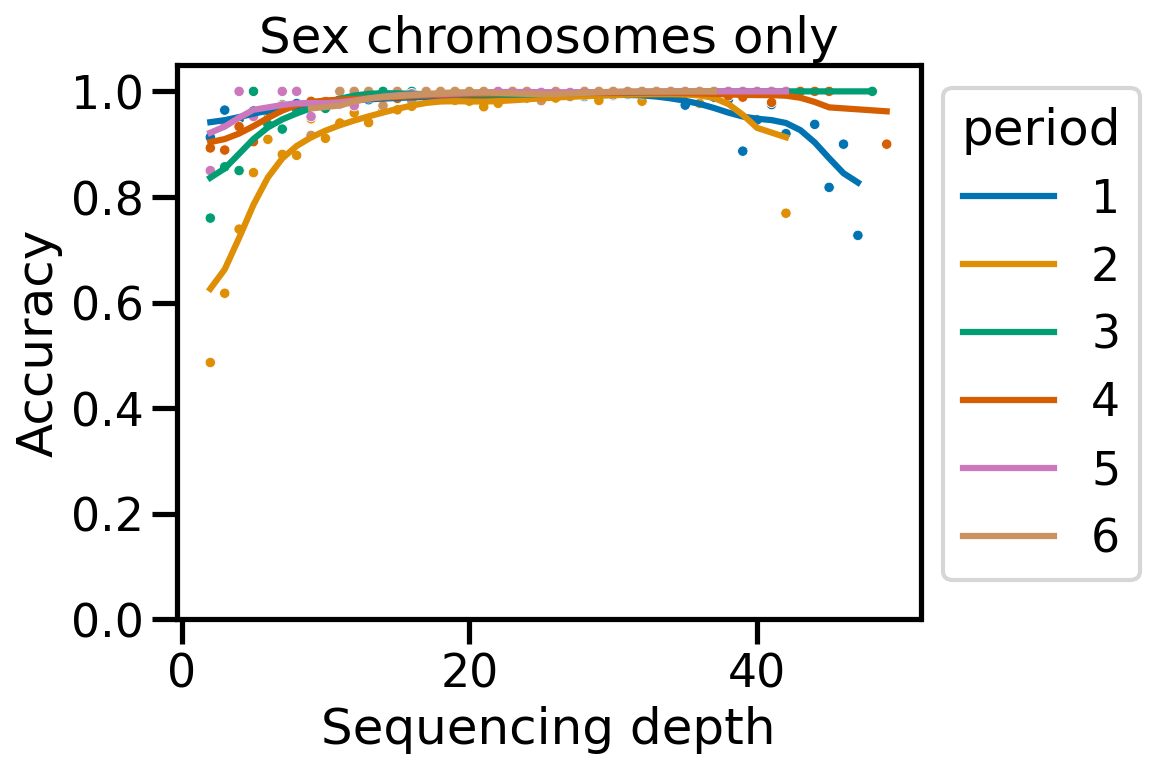

In [35]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_sex,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind"
)

ax = sns.scatterplot(
    df_plot_sex,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title="Sex chromosomes only",
    xlabel = "Sequencing depth",
    ylabel = "Accuracy",
    ylim=(0, 1.05)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()

In [36]:
df_plot_auto = (
    df_comparison
        .merge(df_hg002[["chr", "str_id", "period", "depth"]], on="str_id")
        .query("chr != 'chrX' and chr != 'chrY'")
        .query(f"depth <= {max_depth} and period <= {max_period}")[["match", "period", "depth"]]
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_auto.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_auto = df_plot_auto.assign(smooth = np.concatenate(smooth))

df_plot_auto

,period,depth,accuracy,n_obs,smooth
0,1,2,0.370379,12282,0.562012
1,1,3,0.488185,10072,0.580134
2,1,4,0.603900,10924,0.612843
3,1,5,0.694986,11288,0.654327
4,1,6,0.756415,11458,0.698371
...,...,...,...,...,...
768,6,74,1.000000,38,0.994148
769,6,75,1.000000,25,0.993410
770,6,76,0.960000,25,0.992841
771,6,77,1.000000,17,0.992485


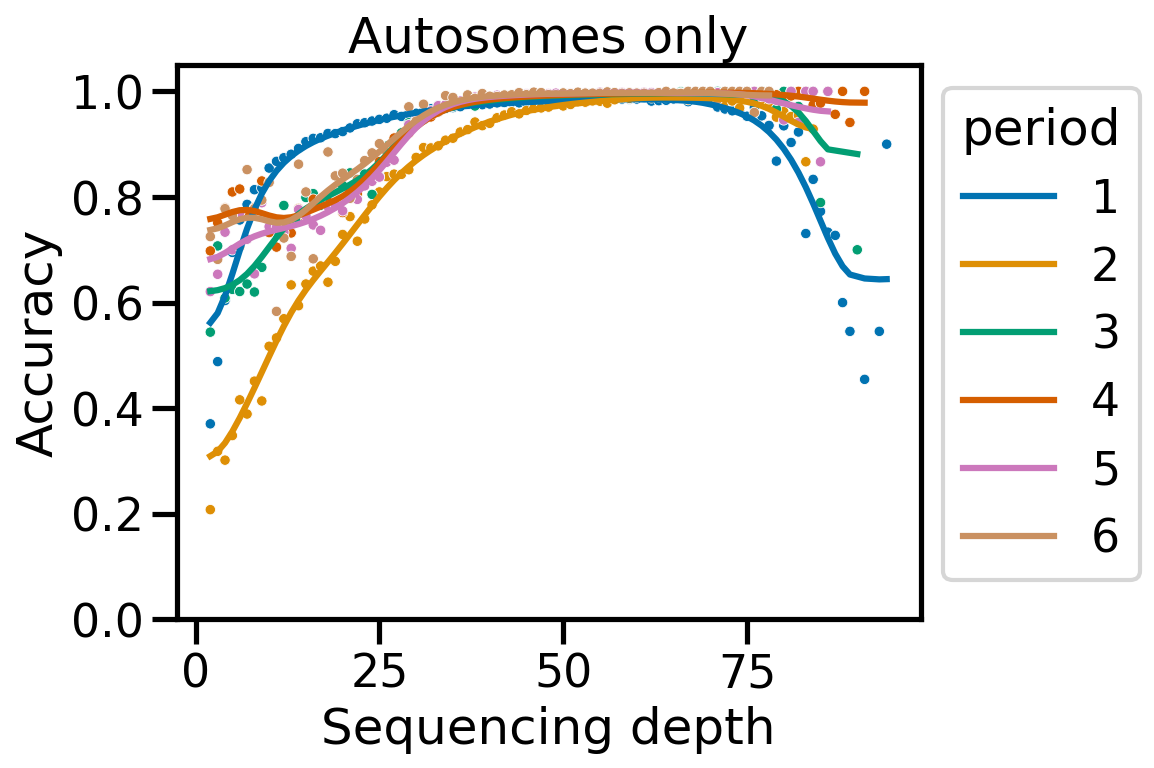

In [37]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_auto,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind"
)

ax = sns.scatterplot(
    df_plot_auto,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title="Autosomes only",
    xlabel = "Sequencing depth",
    ylabel = "Accuracy",
    ylim=(0, 1.05)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()

[None, None]

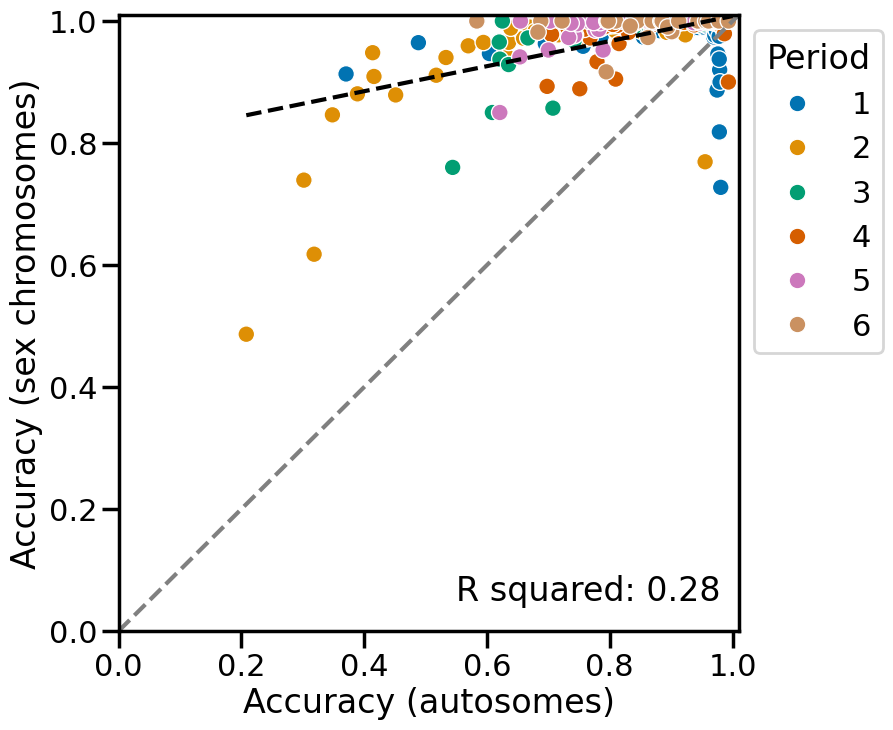

In [38]:
from scipy import stats

df_acc_comparison = df_plot_auto[["period", "depth", "accuracy"]].merge(
        df_plot_sex[["period", "depth", "accuracy"]], 
        on=["period", "depth"], how="inner")

lm = stats.linregress(df_acc_comparison["accuracy_x"], df_acc_comparison["accuracy_y"])

fig = plt.figure(figsize=(8, 8))

ax = sns.scatterplot(
    df_acc_comparison,
    x="accuracy_x",
    y="accuracy_y",
    hue="period",
    palette=sns.color_palette("colorblind")[:6]
)

line = np.linspace(0, 1.1, 1000)
sns.lineplot(
    x=line,
    y=line,
    color="grey",
    linestyle="--",
    ax = ax
)

fit = np.linspace(
    df_acc_comparison[["accuracy_x", "accuracy_y"]].min().min(), 
    df_acc_comparison[["accuracy_x", "accuracy_y"]].max().max(), 
    1000
)
sns.lineplot(
    x=fit,
    y=fit * lm.slope + lm.intercept,
    color="black",
    linestyle="--",
    ax = ax
)

ax.set(
    xlim=(0, 1.01),
    ylim=(0, 1.01),
    xlabel="Accuracy (autosomes)",
    ylabel="Accuracy (sex chromosomes)",
)

ax.text(0.55, 0.05, f"R squared: {lm.rvalue**2:.2f}")

ax.get_legend().set(title="Period", bbox_to_anchor=(1,1))

[None, None]

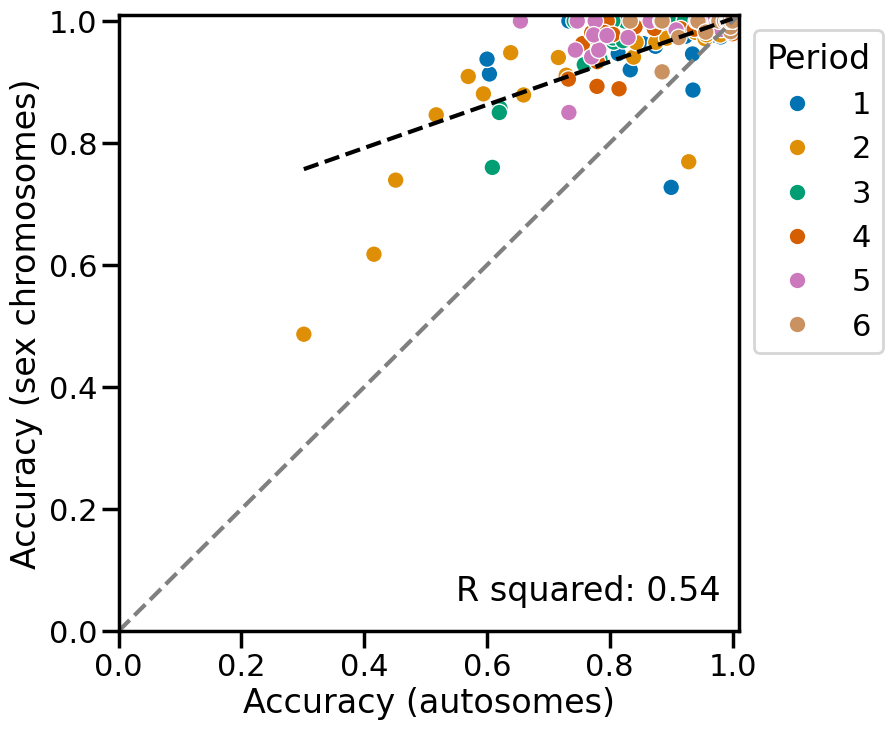

In [39]:
df_acc_comparison_cn = df_plot_auto[["period", "depth", "accuracy"]].merge(
        df_plot_sex[["period", "depth", "accuracy"]].assign(depth = lambda x: x["depth"] * 2), 
        on=["period", "depth"], how="inner")

lm = stats.linregress(df_acc_comparison_cn["accuracy_x"], df_acc_comparison_cn["accuracy_y"])

fig = plt.figure(figsize=(8, 8))

ax = sns.scatterplot(
    df_acc_comparison_cn,
    x="accuracy_x",
    y="accuracy_y",
    hue="period",
    palette=sns.color_palette("colorblind")[:6]
)

line = np.linspace(0, 1.1, 1000)
sns.lineplot(
    x=line,
    y=line,
    color="grey",
    linestyle="--",
    ax = ax
)

fit = np.linspace(
    df_acc_comparison_cn[["accuracy_x", "accuracy_y"]].min().min(), 
    df_acc_comparison_cn[["accuracy_x", "accuracy_y"]].max().max(), 
    1000
)
sns.lineplot(
    x=fit,
    y=fit * lm.slope + lm.intercept,
    color="black",
    linestyle="--",
    ax = ax
)

ax.set(
    xlim=(0, 1.01),
    ylim=(0, 1.01),
    xlabel="Accuracy (autosomes)",
    ylabel="Accuracy (sex chromosomes)",
)

ax.text(0.55, 0.05, f"R squared: {lm.rvalue**2:.2f}")

ax.get_legend().set(title="Period", bbox_to_anchor=(1,1))